# Taylor Expansion of a decoupled System

In the Paper 'Design of Decoupled Controllers for MIMO Systems' by Aström, Johansson and Wang the Decoupling for small frequencies is described.

The following calculation is based on the First Order Time Delay (FOTD) Identification method, which results in a Two Input Two Output (TITO) System for the System in feedforward representation. 

To Decouple the system a Taylor Series around the steady state s=0 is used to derive Interaction from an input to another output. Since we approximate the system always with a FOTD Model, we can derive the interaction:

In [1]:
# Import the needed packages, SymPy
import sympy as sp
from sympy import init_printing
init_printing()

In [2]:
# Define the variables
# Complex variable
s = sp.symbols('s')
# FOTD Coeffficients
T1,T2,T3,T4 = sp.symbols('T_1 T_2 T_3 T_4')
K1,K2,K3,K4 = sp.symbols('K_1 K_2 K_3 K_4')
# Time Delay Coefficients
L1,L2,L3,L4 = sp.symbols('L_1 L_2 L_3 L_4')

# Vectorize
TV = [T1,T2,T3,T4]
KV = [K1,K2,K3,K4]
LV = [L1,L2,L3,L4]

# Define a FOTD
def FOTD(K,T,L):
    return K/(T*s+1) * sp.exp(-L*s)

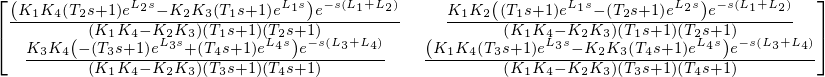

In [3]:
#Define a Matrix of FOTD
G = sp.zeros(2)
for i in range(0,4):
    G[i]= FOTD(KV[i],TV[i],LV[i])

#Get the DC Gain and invert it for Static Decoupling 
G0 = G.subs(s,0)
D = sp.simplify(G0**-1)

#Get the Q Matrix -> the static decoupled system
Q = sp.simplify(G*D)
Q

In [4]:
# Get the Taylor series Expansion for the Interaction of Q approx I + O(s)
k12 = sp.simplify(Q[1].series(s,0,2))
k21 = sp.simplify(Q[2].series(s,0,2))

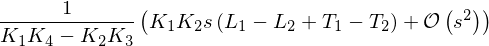

In [5]:
# Print the Interaction of Input 2 on Output 1 in small frequencies
k12

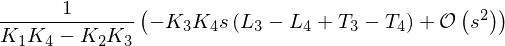

In [8]:
# Print the Interaction of Input 1 on Output 2 in small frequencies
k21

# Interpretation

We can see that the inverse of the determinant of the DCGain is a scaling factor describing the influence of the main diagonal elements in relation to the off diagonal elements. Hence, if the matrix is nearly equal in its gains the interaction is large.

The scaling is completed with the influence of the gains of the row affecting the output.

The results of the calculation give a direct interpretation:
Consider a TITO system described by FOTD functions. The Influence of the static decoupled system Q from an input i on an output j is neglectable iff:

- $T_i = T_j$ and $L_i = L_j$
- $T_i = L_j$ and $T_j = L_i$
- $K_i K_j \leq 1$ and $det(G_0) \geq 1$